<a href="https://colab.research.google.com/github/SeanBarnier/HAFS_Air-Sea/blob/main/tempMaps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Set up environment

In [6]:
!pip install cfgrib
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 103.3 MB/s eta 0:00:00


In [7]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cft
from datetime import datetime as dt
import cfgrib

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#User parameters

In [9]:
name = "Milton"
tcNum = "14"
trackType = ""

initTime = dt(year=2024, month=10, day=6, hour=0) #Time when Milton began its most rapid intensification

fHourStep = 12      #Normally 3 for HAFS-A
forecastLength = 48 #Normally 126 for HAFS-A.
#runStep = 6         #Normally 6 for HAFS-A

figureSuffix = "_RI"
subfolder = "RI/"
dataPath = "/content/drive/MyDrive/savedData/"
figurePath = "/content/drive/MyDrive/figures/"

stormCentered = True
potentialTemp = True #Use atmospheric potential temperature instead of in-situ temperature

atmTop = 850
oceFloor = 100

Get ATCF data and find interested point

#Retrieve HAFS-A Data

Find times needed

In [10]:
dateFormat = "%Y-%m-%d %H:%M:%S"
runFormat = "%Y%m%d%H"

fcastTimes = [] #Key: initiation, item: valid time list
fhour = 0
validTime = initTime

while fhour <= forecastLength:
    fcastTimes.append(validTime)
    validTime += pd.Timedelta(hours=fHourStep)
    fhour += fHourStep

Find storm location in HAFS-A from ATCF files. Used to find along-storm profile.

In [11]:
cols = ["BASIN", "CY", "YYYYMMDDHH", "TECHNUM/MIN", "TECH", "TAU", "LatN/S", "LonE/W",
    "VMAX", "MSLP", "TY", "RAD", "WINDCODE", "RAD1", "RAD2", "RAD3", "RAD4",
    "POUTER", "ROUTER", "RMW", "GUSTS", "EYE", "SUBREGION", "MAXSEAS", "INITIALS",
    "DIR", "SPEED", "STORMNAME", "DEPTH", "SEAS", "SEASCODE", "SEAS1", "SEAS2",
    "SEAS3", "SEAS4", "USERDEFINED1", "Thermo1", "Thermo2", "Thermo3", "Thermo4",
    "Thermo5", "Thermo6", "Thermo7", "USERDEFINED2", "DT", "SHR82", "SHR81_1",
    "SHR82_2",  "USERDEFINED3", "SST", "USERDEFINED4", "ARMW1", "ARMW2"]

initStr, initHour = initTime.strftime("%Y%m%d_%H").split("_")

atcfURL = f"https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/{initStr}/{initHour}/{tcNum}l.{initStr}{initHour}.hfsa.trak.atcfunix"
atcfFile = "atcf_" + initStr + "_" + initHour + ".csv"

!wget -O {atcfFile} {atcfURL}
atcf = pd.read_csv(atcfFile, names=cols)

--2025-07-09 18:16:29--  https://noaa-nws-hafs-pds.s3.amazonaws.com/hfsa/20241006/00/14l.2024100600.hfsa.trak.atcfunix
Resolving noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)... 16.182.67.129, 3.5.24.217, 52.216.61.113, ...
Connecting to noaa-nws-hafs-pds.s3.amazonaws.com (noaa-nws-hafs-pds.s3.amazonaws.com)|16.182.67.129|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33522 (33K) [application/octet-stream]
Saving to: ‘atcf_20241006_00.csv’

atcf_20241006_00.cs 100%[===================>]  32.74K  --.-KB/s    in 0.06s   

2025-07-09 18:16:30 (564 KB/s) - ‘atcf_20241006_00.csv’ saved [33522/33522]



In [12]:
tcLocs = {}

for valid in fcastTimes:
    fHour = int((valid-initTime).total_seconds() / 3600)

    pointLat = int(atcf[atcf.TAU==fHour]["LatN/S"].iloc[0].replace("N", ""))/10
    pointLon = int(atcf[atcf.TAU==fHour]["LonE/W"].iloc[0].replace("W", ""))/-10 #Assume western hemisphere
    tcLocs[valid] = (pointLat, pointLon)

Get data from HAFS-A output.

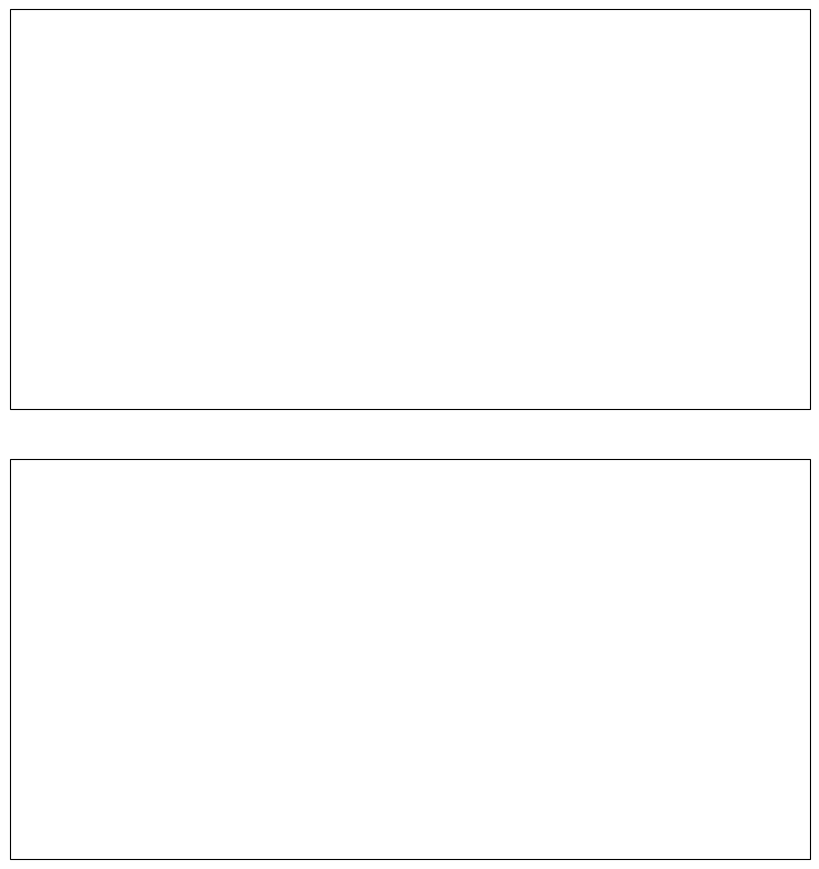

In [78]:
atmFig = plt.figure(figsize=(10,10))
#oceFig = plt.figure(figsize=(10,10))

axWidth = 8 / len(fcastTimes)
atmAxes = [atmFig.add_axes([xcorner,0.5, axWidth-0.05, 0.4], projection=ccrs.PlateCarree()) for xcorner in np.arange(0.1,0.9,axWidth)]
oceAxes = [atmFig.add_axes([xcorner,0.05, axWidth-0.05, 0.4], projection=ccrs.PlateCarree()) for xcorner in np.arange(0.1,0.9,axWidth)]

#oceAx.set_extent([min(atmData.longitude.data), max(atmData.longitude.data), min(atmData.latitude.data), max(atmData.latitude.data)])

In [79]:
initStr = initTime.strftime("%Y%m%d%H")
atmLayer = 1000.0

for valid, atmAx in zip(fcastTimes, atmAxes):

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  atmFile = "hafsa_" + initStr + "_f" + fhour + ".nc"
  atmPath = dataPath + "hafsaOutput/" + subfolder + atmFile
  atmData = xr.open_dataset(atmPath)

  atmAx.imshow(atmData.sel(isobaricInhPa=atmLayer).t.data)
  #atmAx.set_extent([min(atmData.longitude.data)-360, max(atmData.longitude.data)-360, min(atmData.latitude.data), max(atmData.latitude.data)])
  #atmAx.add_feature(cft.COASTLINE)
  #atmAx.add_feature(cft.BORDERS)

/tmp/ipython-input-79-146573911.py:11: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  atmData = xr.open_dataset(atmPath)


In [80]:
oceLayer = 1.0

for valid, oceAx in zip(fcastTimes, oceAxes):

  initStr = initTime.strftime("%Y%m%d%H")

  fhour = str(int((valid-initTime).total_seconds() / 3600))
  while len(fhour) < 3: fhour = "0" + fhour

  oceFile = "mom6_" + initStr + "_f" + fhour + ".nc"
  ocePath = dataPath + "mom6Output/" + subfolder + oceFile
  #oceData = xr.open_dataset(ocePath, decode_times=False).sel(time=0.1, method='nearest')

  oceAx.imshow(oceData.sel(z_l=oceLayer).temp.data)
  #oceAx.add_feature(cft.COASTLINE)
  #oceAx.add_feature(cft.BORDERS)

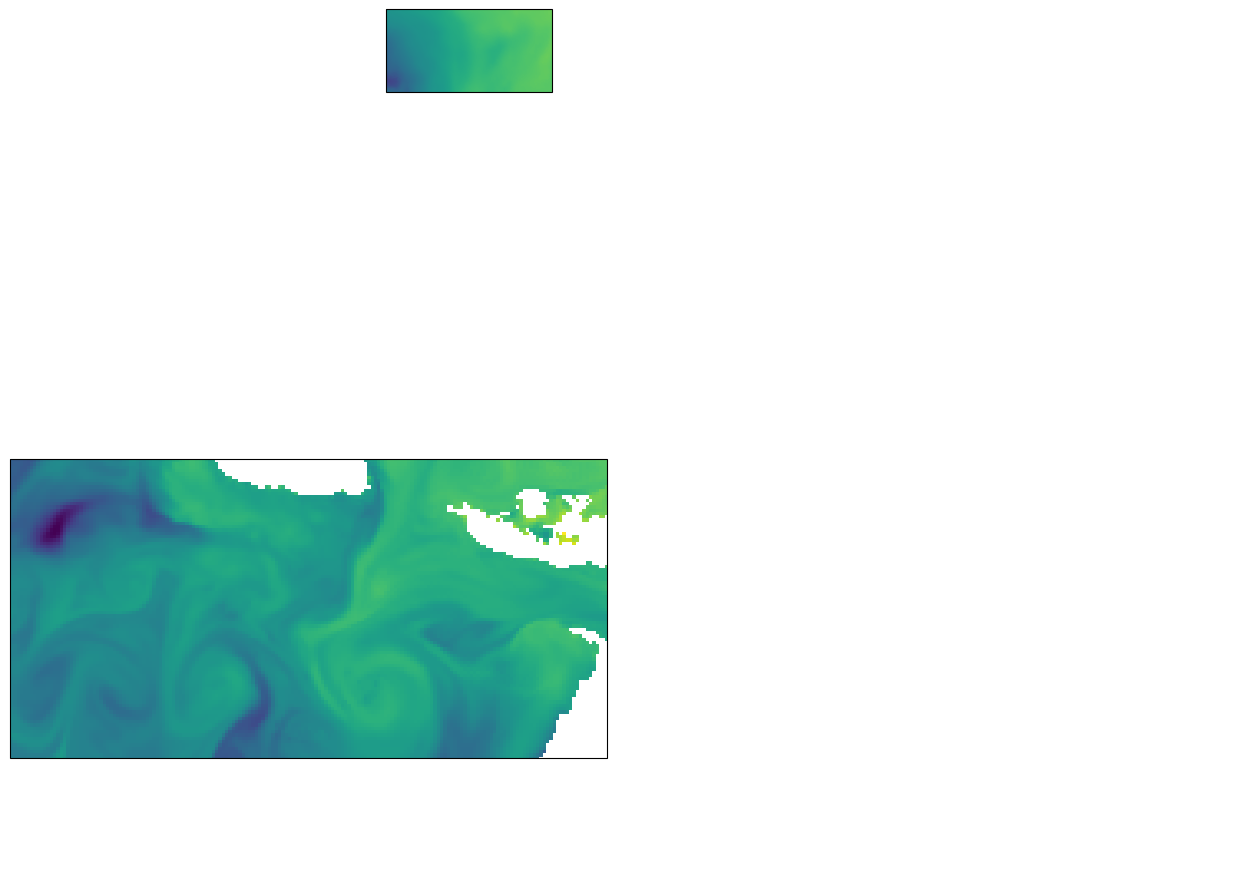

In [81]:
atmFig